# Nifty Intraday Demo — End-to-end pipeline
This notebook demonstrates:
- Loading minute OHLCV CSV
- Feature engineering (technical indicators + flattened lag features)
- Labeling (1-minute horizon, 3-class)
- Train/val/test split (time-based)
- Training a LightGBM classifier
- Evaluating and backtesting a classifier-driven trading strategy
- Saving model & scaler artifacts
- Example inference on most recent LAST_T minutes

Adjust parameters in the configuration cell before running.

In [7]:
# (Optional) Install required packages in notebook environment (uncomment if needed)
# !pip install pandas numpy scikit-learn lightgbm ta joblib matplotlib seaborn

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import joblib
import ta
import json
from datetime import datetime

# ---------- CONFIG ----------
CSV_PATH = "nifty_minute.csv"   # change to your CSV location
DATE_COL = "date"           # change if your datetime column differs
HORIZON = 1
LAST_T = 10
TAU_PCT = 0.0001
TRAIN_END_DATE = "2023-12-31"
VAL_END_DATE = "2024-12-31"
INITIAL_CAPITAL = 100000.0

QUICK_DEBUG = False  # set True to run on recent subset for faster iteration
SAMPLE_DAYS = 180    # when QUICK_DEBUG=True use last SAMPLE_DAYS days

ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

plt.style.use("dark_background")

In [8]:
def compute_technical_indicators(df):
    df = df.copy()
    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df['open']  = pd.to_numeric(df['open'], errors='coerce')
    df['high']  = pd.to_numeric(df['high'], errors='coerce')
    df['low']   = pd.to_numeric(df['low'], errors='coerce')
    df['volume'] = pd.to_numeric(df.get('volume', 0), errors='coerce').fillna(0)
    df['return_1'] = df['close'].pct_change().fillna(0)
    df['logret_1'] = np.log(df['close'] / df['close'].shift(1)).fillna(0)
    # indicators via ta (fillna True to avoid NaNs)
    df['sma_5'] = ta.trend.SMAIndicator(df['close'], window=5, fillna=True).sma_indicator()
    df['sma_10'] = ta.trend.SMAIndicator(df['close'], window=10, fillna=True).sma_indicator()
    df['ema_8'] = ta.trend.EMAIndicator(df['close'], window=8, fillna=True).ema_indicator()
    df['rsi_14'] = ta.momentum.RSIIndicator(df['close'], window=14, fillna=True).rsi()
    bb = ta.volatility.BollingerBands(df['close'], window=20, fillna=True)
    df['bb_h'] = bb.bollinger_hband()
    df['bb_l'] = bb.bollinger_lband()
    df['atr_14'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14, fillna=True)
    return df

def build_flattened_features(df, last_t=LAST_T):
    rows = []
    idxs = []
    n = len(df)
    for i in range(last_t, n - HORIZON):
        window = df.iloc[i-last_t:i]
        cur = df.iloc[i]
        feat = {}
        # lagged features: lag 1 = most recent in window
        for j in range(last_t):
            row = window.iloc[j]
            lag = last_t - j
            feat[f'close_lag_{lag}'] = row['close']
            feat[f'ret_lag_{lag}'] = row['return_1']
            feat[f'vol_lag_{lag}'] = row['volume']
        # snapshot
        feat['close_now'] = cur['close']
        feat['sma_5_now'] = cur['sma_5']
        feat['ema_8_now'] = cur['ema_8']
        feat['rsi_14_now'] = cur['rsi_14']
        feat['atr_14_now'] = cur['atr_14']
        rows.append(feat)
        idxs.append(df.index[i])
    X = pd.DataFrame(rows, index=idxs)
    return X

def build_labels(df, X_index, horizon=HORIZON, tau=TAU_PCT):
    future = df['close'].shift(-horizon).reindex(X_index)
    current = df['close'].reindex(X_index)
    ret = (future.values - current.values) / current.values
    labels = np.where(ret > tau, 2, np.where(ret < -tau, 0, 1))  # 2=Up,1=Neutral,0=Down
    return pd.Series(labels, index=X_index)

In [9]:
print("Loading CSV:", CSV_PATH)
df = pd.read_csv(CSV_PATH)

# ensure datetime
if DATE_COL not in df.columns:
    # attempt common alternatives
    if 'DateTime' in df.columns:
        DATE_COL = 'DateTime'
    elif 'date' in df.columns:
        DATE_COL = 'date'
    else:
        raise ValueError("Datetime column not found; please set DATE_COL correctly.")
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)

# optionally keep market hours (safe even if outside)
try:
    df = df.between_time("09:15", "15:30")
except Exception:
    pass

print("Data range:", df.index.min(), "->", df.index.max())
print("Columns:", df.columns.tolist())
print("Sample rows:")
display(df.head(8))

Loading CSV: nifty_minute.csv
Data range: 2015-01-09 09:15:00 -> 2025-07-25 15:29:00
Columns: ['open', 'high', 'low', 'close', 'volume']
Sample rows:


,open,high,low,close,volume
date,,,,,
2015-01-09 09:15:00,8285.45,8295.90,8285.45,8292.10,0
2015-01-09 09:16:00,8292.60,8293.60,8287.20,8288.15,0
2015-01-09 09:17:00,8287.40,8293.90,8287.40,8293.90,0
2015-01-09 09:18:00,8294.25,8300.65,8293.90,8300.65,0
2015-01-09 09:19:00,8300.60,8301.30,8298.75,8301.20,0
2015-01-09 09:20:00,8300.50,8303.00,8298.60,8300.00,0
2015-01-09 09:21:00,8300.65,8302.90,8300.00,8301.85,0
2015-01-09 09:22:00,8302.45,8302.45,8295.00,8295.00,0


In [10]:
if QUICK_DEBUG:
    # keep last SAMPLE_DAYS of data for faster runs
    last_date = df.index.date[-1]
    cutoff = pd.to_datetime(last_date) - pd.Timedelta(days=SAMPLE_DAYS)
    df = df.loc[df.index >= cutoff]
    print("QUICK_DEBUG active. Using recent subset from", df.index.min(), "to", df.index.max())

In [11]:
print("Computing technical indicators...")
df = compute_technical_indicators(df)
display(df[['close','return_1','sma_5','ema_8','rsi_14','atr_14']].head(8))

Computing technical indicators...


,close,return_1,sma_5,ema_8,rsi_14,atr_14
date,,,,,,
2015-01-09 09:15:00,8292.10,0.000000,8292.100000,8292.100000,100.000000,0.0
2015-01-09 09:16:00,8288.15,-0.000476,8290.125000,8291.222222,0.000000,0.0
2015-01-09 09:17:00,8293.90,0.000694,8291.383333,8291.817284,61.054228,0.0
2015-01-09 09:18:00,8300.65,0.000814,8293.700000,8293.780110,78.019789,0.0
2015-01-09 09:19:00,8301.20,0.000066,8295.200000,8295.428974,78.829056,0.0
2015-01-09 09:20:00,8300.00,-0.000145,8296.780000,8296.444758,72.552578,0.0
2015-01-09 09:21:00,8301.85,0.000223,8299.520000,8297.645923,75.757271,0.0
2015-01-09 09:22:00,8295.00,-0.000825,8299.740000,8297.057940,51.691211,0.0


In [12]:
print("Building flattened features (may take a moment)...")
X = build_flattened_features(df, last_t=LAST_T)
y = build_labels(df, X.index, horizon=HORIZON, tau=TAU_PCT)
mask = ~(X.isna().any(axis=1) | pd.isna(y))
X = X.loc[mask]
y = y.loc[mask]
print("Feature matrix shape:", X.shape)
print("Label distribution (counts):")
display(y.value_counts().sort_index())

Building flattened features (may take a moment)...
Feature matrix shape: (974698, 35)
Label distribution (counts):


0    324634
1    321669
2    328395
Name: count, dtype: int64

In [13]:
dates = X.index.normalize()
train_mask = dates <= pd.to_datetime(TRAIN_END_DATE)
val_mask   = (dates > pd.to_datetime(TRAIN_END_DATE)) & (dates <= pd.to_datetime(VAL_END_DATE))
test_mask  = dates > pd.to_datetime(VAL_END_DATE)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val, y_val     = X.loc[val_mask], y.loc[val_mask]
X_test, y_test   = X.loc[test_mask], y.loc[test_mask]

print("Sizes (train / val / test):", X_train.shape, X_val.shape, X_test.shape)

Sizes (train / val / test): (828995, 35) (92454, 35) (53249, 35)


In [14]:
num_cols = X_train.columns.tolist()
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_val_s   = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols, index=X_val.index)
X_test_s  = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

In [15]:
print("Training LightGBM classifier...")
clf = LGBMClassifier(objective='multiclass', num_class=3, learning_rate=0.05,
                     n_estimators=1000, num_leaves=31, random_state=42, n_jobs=-1)

from lightgbm import early_stopping, log_evaluation
clf.fit(X_train_s, y_train,
        eval_set=[(X_val_s, y_val)],
        eval_metric='multi_logloss',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=50)])

Training LightGBM classifier...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 828995, number of used features: 25
[LightGBM] [Info] Start training from score -1.093986
[LightGBM] [Info] Start training from score -1.120401
[LightGBM] [Info] Start training from score -1.081838
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 1.07027
[100]	valid_0's multi_logloss: 1.06779
[150]	valid_0's multi_logloss: 1.06773
Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 1.06772


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [16]:
print("Validation evaluation:")
preds_val = clf.predict(X_val_s)
print(classification_report(y_val, preds_val, digits=4))
print("Confusion matrix (val):")
print(confusion_matrix(y_val, preds_val))

Validation evaluation:
              precision    recall  f1-score   support

           0     0.3816    0.2065    0.2680     30204
           1     0.4724    0.5172    0.4938     31811
           2     0.3673    0.4982    0.4229     30439

    accuracy                         0.4094     92454
   macro avg     0.4071    0.4073    0.3949     92454
weighted avg     0.4082    0.4094    0.3967     92454

Confusion matrix (val):
[[ 6238  9176 14790]
 [ 4031 16453 11327]
 [ 6077  9198 15164]]


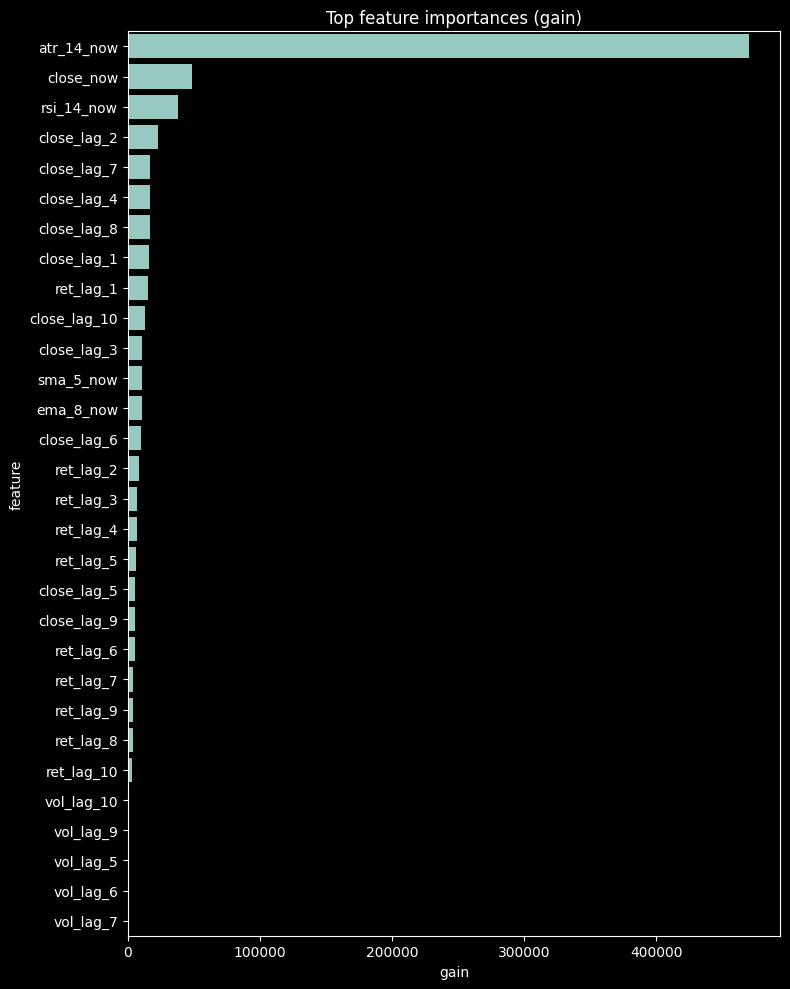

In [17]:
# Get feature importance from LightGBM booster
try:
    fi = clf.booster_.feature_importance(importance_type='gain')
    feat_names = num_cols
    fi_df = pd.DataFrame({'feature': feat_names, 'gain': fi})
    fi_df = fi_df.sort_values('gain', ascending=False).head(30)
    plt.figure(figsize=(8,10))
    sns.barplot(x='gain', y='feature', data=fi_df)
    plt.title("Top feature importances (gain)")
    plt.tight_layout()
    plt.show()
except Exception:
    print("Could not get booster feature importance; using sklearn feature_importances_ fallback")
    fi_df = pd.DataFrame({'feature': num_cols, 'imp': clf.feature_importances_}).sort_values('imp', ascending=False).head(30)
    plt.figure(figsize=(8,10))
    sns.barplot(x='imp', y='feature', data=fi_df)
    plt.show()

In [18]:
print("Merging classifier probabilities into df for backtest...")
X_all = pd.concat([X_train, X_val, X_test])
X_all_s = pd.DataFrame(scaler.transform(X_all[num_cols]), columns=num_cols, index=X_all.index)
probs_all = clf.predict_proba(X_all_s)
prob_df = pd.DataFrame(probs_all, index=X_all.index, columns=['prob_dn','prob_neu','prob_up'])

df_with_probs = df.merge(prob_df, left_index=True, right_index=True, how='left')
df_with_probs[['prob_dn','prob_neu','prob_up']] = df_with_probs[['prob_dn','prob_neu','prob_up']].fillna(method='ffill').fillna(1/3)
# Also merge flattened features so day slices contain lag cols
X_full = build_flattened_features(df_with_probs, last_t=LAST_T)
df_with_probs = df_with_probs.merge(X_full, left_index=True, right_index=True, how='left')
df_with_probs = df_with_probs.dropna(subset=[f'close_lag_1'])  # ensure lag features present
print("Merged df shape:", df_with_probs.shape)

Merging classifier probabilities into df for backtest...
Merged df shape: (974698, 52)


In [24]:
def build_signals_for_times(model, scaler, X_df, raw_df, horizon=HORIZON, min_prob=0.40):
    Xs_s = pd.DataFrame(scaler.transform(X_df[num_cols]), columns=num_cols, index=X_df.index)
    probs = model.predict_proba(Xs_s)
    preds = np.argmax(probs, axis=1)
    df_sign = pd.DataFrame(index=X_df.index)
    df_sign['price_t'] = raw_df['close'].reindex(X_df.index)
    df_sign['price_exec'] = raw_df['close'].shift(-horizon).reindex(X_df.index)
    df_sign['pred_class'] = preds
    df_sign['pred_label'] = df_sign['pred_class'].map({0:'Down',1:'Neutral',2:'Up'})
    df_sign['prob_max'] = probs.max(axis=1)
    df_sign['prob_up']  = probs[:, 2]
    df_sign['prob_neu'] = probs[:, 1]
    df_sign['prob_dn']  = probs[:, 0]
    def decide(row):
        if row['prob_max'] < min_prob: return 0
        if row['pred_label'] == 'Up': return 1
        if row['pred_label'] == 'Down': return -1
        return 0
    df_sign['signal'] = df_sign.apply(decide, axis=1)
    df_sign = df_sign.dropna(subset=['price_exec'])
    return df_sign

def run_backtest_with_stops(df_sign, raw_df,
                           initial_capital=100000.0,
                           position_size=0.1,
                           stop_loss_pct=0.002,    # 0.2% stop
                           take_profit_pct=None,   # e.g., 0.01 for 1% TP; None = no TP
                           trailing_stop=False,
                           exit_on_reversal=True,
                           round_trip_cost=0.0003,
                           hold_max_bars=390):
    """
    Event-driven backtest with stop-loss and (optional) take-profit and trailing stop.
    - df_sign: index aligned to timestamps; must contain 'price_exec' and 'signal' (1/0/-1).
    - raw_df: original OHLCV DataFrame keyed by same timestamps (used for high/low checks).
    Returns DataFrame with equity series and trade log.
    """
    equity = initial_capital
    equity_hist = []
    timestamps = list(df_sign.index)
    n = len(timestamps)
    # Position state
    pos = 0                   # -1 short, 0 flat, +1 long
    entry_price = None
    entry_notional = 0.0
    units = 0.0
    stop_price = None
    take_price = None
    entry_idx = None
    trade_log = []
    for i, t in enumerate(timestamps):
        sig = int(df_sign.at[t, 'signal']) if 'signal' in df_sign.columns else 0
        # execution price for opening at this time (price at t+h previously stored)
        entry_exec_price = df_sign.at[t, 'price_exec']
        # Determine price path during this bar for stop/take checks: prefer high/low if available
        # Use raw_df at timestamp t+horizon and t+horizon+1? For simplicity, use raw_df.loc[t+horizon] high/low if present
        # Here we use the raw_df row at the same index t (assuming shifts were already applied in df_sign for price_exec)
        if t in raw_df.index:
            row = raw_df.loc[t]
            hi = row.get('high', np.nan)
            lo = row.get('low', np.nan)
            close = row.get('close', np.nan)
        else:
            hi = lo = close = entry_exec_price

        # First, check if there's an open position and whether stop/take is hit during this bar
        realized_pnl = 0.0
        closed = False
        if pos != 0:
            # For long: stop if lo <= stop_price; take if hi >= take_price
            if pos == 1:
                # trailing stop: stop_price may have moved up previously
                hit_stop = (not np.isnan(lo) and stop_price is not None and lo <= stop_price)
                hit_take = (take_price is not None and not np.isnan(hi) and hi >= take_price)
                if hit_stop:
                    exit_price = stop_price
                    closed = True
                    reason = 'stop'
                elif hit_take:
                    exit_price = take_price
                    closed = True
                    reason = 'take'
            else:  # pos == -1 short
                # for short, stop if hi >= stop_price (adverse), take if lo <= take_price (profitable)
                hit_stop = (not np.isnan(hi) and stop_price is not None and hi >= stop_price)
                hit_take = (take_price is not None and not np.isnan(lo) and lo <= take_price)
                if hit_stop:
                    exit_price = stop_price
                    closed = True
                    reason = 'stop'
                elif hit_take:
                    exit_price = take_price
                    closed = True
                    reason = 'take'

            # If no stop/take hit but reversal signal and exit_on_reversal=True, close at entry_exec_price (or close)
            if (not closed) and exit_on_reversal and sig == -pos:
                # reversal: close at entry_exec_price (which is df_sign.price_exec at time t)
                exit_price = entry_exec_price
                closed = True
                reason = 'reversal'

            # If still open and hold_max_bars exceeded, force close at close price
            if (not closed) and entry_idx is not None and (i - entry_idx) >= hold_max_bars:
                exit_price = close if not np.isnan(close) else entry_exec_price
                closed = True
                reason = 'max_hold'

            if closed:
                # compute pnl: units * (exit - entry) * sign
                raw_pnl = units * (exit_price - entry_price) * pos
                tc = round_trip_cost * entry_notional  # apply cost proportional to notional
                realized_pnl = raw_pnl - tc
                equity += realized_pnl
                trade_log.append({
                    'entry_time': entry_time,
                    'exit_time': t,
                    'side': 'long' if pos==1 else 'short',
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'notional': entry_notional,
                    'pnl': realized_pnl,
                    'reason': reason
                })
                # reset position
                pos = 0
                entry_price = None
                units = 0.0
                entry_notional = 0.0
                stop_price = None
                take_price = None
                entry_idx = None
                entry_time = None

        # After checking existing position closure, possibly open new position if signal requests and flat
        if pos == 0 and sig != 0:
            # open position at entry_exec_price
            pos = sig
            entry_price = entry_exec_price
            entry_notional = position_size * equity
            units = entry_notional / entry_price if entry_price != 0 else 0.0
            entry_idx = i
            entry_time = t
            # set stop & take
            if pos == 1:
                stop_price = entry_price * (1.0 - stop_loss_pct)
                take_price = entry_price * (1.0 + take_profit_pct) if take_profit_pct is not None else None
            else:
                stop_price = entry_price * (1.0 + stop_loss_pct)
                take_price = entry_price * (1.0 - take_profit_pct) if take_profit_pct is not None else None
            # record open (no immediate cost subtracted; cost applied on close)
            # optionally apply entry slippage here: reduce units or adjust entry_price

        equity_hist.append(equity)

    # build results
    eq_idx = timestamps[:len(equity_hist)]
    res = pd.DataFrame(index=eq_idx)
    res['equity'] = equity_hist
    trades_df = pd.DataFrame(trade_log)
    return res, trades_df    

def compute_metrics(equity_series, initial_capital=INITIAL_CAPITAL):
    total_return = equity_series.iloc[-1] - initial_capital
    return_pct = total_return / initial_capital
    rets = equity_series.pct_change().fillna(0)
    minutes_per_year = 252 * 390
    mean_min = rets.mean()
    std_min = rets.std() if rets.std() > 0 else 1e-9
    sharpe_anno = (mean_min / std_min) * np.sqrt(minutes_per_year)
    running_max = equity_series.cummax()
    drawdown = (equity_series - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'final_equity': float(equity_series.iloc[-1]),
        'total_return_abs': float(total_return),
        'total_return_pct': float(return_pct),
        'sharpe_approx': float(sharpe_anno),
        'max_drawdown': float(max_dd)
    }

Final equity: 85745.54818202632
Trades summary:


,entry_time,exit_time,side,entry_price,exit_price,notional,pnl,reason
0,2025-01-01 09:15:00,2025-01-01 09:16:00,short,23644.10,23655.90,10000.000000,-7.990674,reversal
1,2025-01-01 09:16:00,2025-01-01 09:18:00,long,23655.90,23675.65,9999.200933,5.348441,reversal
2,2025-01-01 09:18:00,2025-01-01 09:20:00,short,23675.65,23635.55,9999.735777,13.936865,reversal
3,2025-01-01 09:20:00,2025-01-01 09:25:00,long,23635.55,23633.75,10001.129463,-3.761990,reversal
4,2025-01-01 09:25:00,2025-01-01 09:26:00,short,23633.75,23632.35,10000.753264,-2.407808,reversal


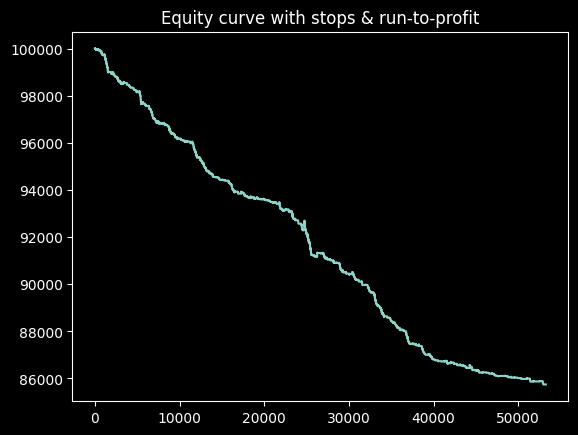

In [25]:
df_sign_test = build_signals_for_times(clf, scaler, X_test, df_with_probs, horizon=HORIZON, min_prob=0.40)
res_stops, trades = run_backtest_with_stops(df_sign_test, df_with_probs,
                                           initial_capital=100000.0,
                                           position_size=0.1,
                                           stop_loss_pct=0.002,
                                           take_profit_pct=None,
                                           trailing_stop=False,
                                           exit_on_reversal=True,
                                           round_trip_cost=0.0003,
                                           hold_max_bars=390)
print("Final equity:", res_stops['equity'].iloc[-1])
print("Trades summary:")
display(trades.head())
plt.plot(res_stops['equity'].values)
plt.title("Equity curve with stops & run‑to‑profit")
plt.show()

In [ ]:
# Multi-timeframe evaluation: try several resampling intervals and compare metrics
timeframes = ['1T', '5T', '15T', '60T', '1D']   # adjust as needed
results = []

# Parameters for modelling & backtest (shared)
BASE_LAST_T = 10          # number of bars used as window for each timeframe
BASE_TAU = TAU_PCT        # threshold for labeling
MIN_PROB = 0.40
STOP_LOSS_PCT = 0.002     # 0.2%
TAKE_PROFIT_PCT = None
POSITION_SIZE = 0.1
ROUND_TRIP_COST = 0.0003

# Reusable train+eval function for a given resampled df
def evaluate_timeframe(resampled_df, timeframe_label):
    # 1) compute indicators (already need OHLCV columns)
    df_tf = compute_technical_indicators(resampled_df)
    # 2) build flattened features (uses BASE_LAST_T bars)
    X_tf = build_flattened_features(df_tf, last_t=BASE_LAST_T)
    y_tf = build_labels(df_tf, X_tf.index, horizon=1, tau=BASE_TAU)
    mask = ~(X_tf.isna().any(axis=1) | pd.isna(y_tf))
    X_tf = X_tf.loc[mask]
    y_tf = y_tf.loc[mask]
    if len(X_tf) < 1000:
        print(f"[{timeframe_label}] Not enough samples ({len(X_tf)}) — skipping")
        return None
    # 3) time-based split relative to available dates (reuse TRAIN_END_DATE/VAL_END_DATE)
    dates = X_tf.index.normalize()
    train_mask = dates <= pd.to_datetime(TRAIN_END_DATE)
    val_mask   = (dates > pd.to_datetime(TRAIN_END_DATE)) & (dates <= pd.to_datetime(VAL_END_DATE))
    test_mask  = dates > pd.to_datetime(VAL_END_DATE)
    if train_mask.sum() < 100 or test_mask.sum() < 50:
        print(f"[{timeframe_label}] Insufficient train/test samples, skipping")
        return None
    X_tr, y_tr = X_tf.loc[train_mask], y_tf.loc[train_mask]
    X_val, y_val = X_tf.loc[val_mask], y_tf.loc[val_mask]
    X_test, y_test = X_tf.loc[test_mask], y_tf.loc[test_mask]
    # 4) scale (fit scaler on train only)
    scaler_tf = StandardScaler()
    num_cols_tf = X_tr.columns.tolist()
    X_tr_s = pd.DataFrame(scaler_tf.fit_transform(X_tr[num_cols_tf]), columns=num_cols_tf, index=X_tr.index)
    X_val_s = pd.DataFrame(scaler_tf.transform(X_val[num_cols_tf]), columns=num_cols_tf, index=X_val.index)
    X_test_s = pd.DataFrame(scaler_tf.transform(X_test[num_cols_tf]), columns=num_cols_tf, index=X_test.index)
    # 5) train LightGBM baseline
    clf_tf = LGBMClassifier(objective='multiclass', num_class=3, learning_rate=0.05,
                            n_estimators=500, num_leaves=31, random_state=42, n_jobs=-1)
    clf_tf.fit(X_tr_s, y_tr, eval_set=[(X_val_s, y_val)], eval_metric='multi_logloss',
               callbacks=[early_stopping(stopping_rounds=30), log_evaluation(period=50)])
    # 6) merge probs into df_tf for backtest
    X_all_tf = pd.concat([X_tr, X_val, X_test])
    X_all_s_tf = pd.DataFrame(scaler_tf.transform(X_all_tf[num_cols_tf]), columns=num_cols_tf, index=X_all_tf.index)
    probs_all_tf = clf_tf.predict_proba(X_all_s_tf)
    prob_df_tf = pd.DataFrame(probs_all_tf, index=X_all_tf.index, columns=['prob_dn','prob_neu','prob_up'])
    df_with_probs_tf = df_tf.merge(prob_df_tf, left_index=True, right_index=True, how='left')
    df_with_probs_tf[['prob_dn','prob_neu','prob_up']] = df_with_probs_tf[['prob_dn','prob_neu','prob_up']].fillna(method='ffill').fillna(1/3)
    # merge flattened X (so df has lag cols)
    X_full_tf = build_flattened_features(df_with_probs_tf, last_t=BASE_LAST_T)
    df_with_probs_tf = df_with_probs_tf.merge(X_full_tf, left_index=True, right_index=True, how='left')
    df_with_probs_tf = df_with_probs_tf.dropna(subset=[f'close_lag_1'])
    # 7) build signals on test set and run backtest with stops
    # Build test X index aligned to df_with_probs_tf
    X_test_aligned = X_test  # already aligned
    df_sign_test_tf = build_signals_for_times(clf_tf, scaler_tf, X_test_aligned, df_with_probs_tf, horizon=1, min_prob=MIN_PROB)
    res_tf, trades_tf = run_backtest_with_stops(df_sign_test_tf, df_with_probs_tf,
                                                initial_capital=INITIAL_CAPITAL,
                                                position_size=POSITION_SIZE,
                                                stop_loss_pct=STOP_LOSS_PCT,
                                                take_profit_pct=TAKE_PROFIT_PCT,
                                                trailing_stop=False,
                                                exit_on_reversal=True,
                                                round_trip_cost=ROUND_TRIP_COST,
                                                hold_max_bars=1000)
    metrics_tf = compute_metrics(res_tf['equity'], initial_capital=INITIAL_CAPITAL)
    metrics_tf.update({'timeframe': timeframe_label, 'n_trades': len(trades_tf)})
    return {'metrics': metrics_tf, 'equity': res_tf, 'trades': trades_tf, 'clf': clf_tf, 'scaler': scaler_tf, 'df': df_with_probs_tf}

# Loop over timeframes
all_results = {}
for tf in timeframes:
    print("Evaluating timeframe:", tf)
    if tf == '1T':
        df_tf = df.copy()
    else:
        # Resample OHLCV: for '1D' use '1D' freq; for minutes '5T' etc.
        agg = {
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        }
        df_tf = df.resample(tf).agg(agg).dropna()
    result = evaluate_timeframe(df_tf, tf)
    if result is not None:
        all_results[tf] = result

# Summarize metrics
summary_rows = []
for tf, res in all_results.items():
    m = res['metrics']
    summary_rows.append({k: m[k] for k in ['timeframe','final_equity','total_return_pct','sharpe_approx','max_drawdown','n_trades']})
summary_df = pd.DataFrame(summary_rows).set_index('timeframe').sort_values('final_equity', ascending=False)
print("Summary across timeframes:")
display(summary_df)
# Plot equity curves for top 3 timeframes
top_n = min(3, len(all_results))
top_tf = summary_df.index.tolist()[:top_n]
plt.figure(figsize=(12,6))
for tf in top_tf:
    eq = all_results[tf]['equity']['equity'].reset_index(drop=True)
    plt.plot(eq.values, label=tf)
plt.legend()
plt.title("Equity curves (test set) — top timeframes")
plt.show()

Evaluating timeframe: 1T


In [ ]:
print("Saving artifacts to", ARTIFACT_DIR)
joblib.dump(scaler, os.path.join(ARTIFACT_DIR, "scaler.joblib"))
joblib.dump(clf, os.path.join(ARTIFACT_DIR, "lightgbm_clf.joblib"))
# save feature list & config
meta = {
    "num_cols": num_cols,
    "LAST_T": LAST_T,
    "HORIZON": HORIZON,